# Final Project Title goes here

## Step 1: Problem Definition
**<span style="color:red;">TODO:</span> @Nicholas, @Logan define your objective/problem definition here. Here are some questions you should consider:**

1. **Business Objective**: What is the business problem you want to solve? What is the overarching goal or objective of the project?

2. **Problem Type**: What type of problem are you trying to solve? Is it a regression problem (predicting a continuous value), classification problem (assigning labels to instances), clustering problem (grouping similar instances together), time series forecasting (predicting future values based on past observations), or something else?

3. **Stakeholders**: Who are the stakeholders or end users of the solution?

## Step 2: Acquiring and loading the data set
**<span style="color:red;">TODO:</span> @Nicholas, @Logan you should provide some context about your dataset. Here are some questions you should consider:**

1. **Source of the Data:** Where did the dataset come from? Is it publicly available data, data from a specific research project, or data from a company or organization?

2. **Variables and Features:** What do each of the columns represent? For example:
- `Model`: The make and model of the vehicle
- `Displ`: Engine displacement in liters.
- ...

3. **Data Collection**: How did you collect the data?

### Imports

In [50]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import re

# Set display options to show all columns
pd.set_option('display.max_columns', None)

### Loading the dataset

In [51]:
# List of directories containing raw data files
directories = ["../data/raw/2000/"]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through each directory
for directory in directories:
    # Extract the substring containing the year prefix (e.g. "20") using slicing
    year_prefix = directory.split("/")[-2][:2]

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx") or filename.endswith(".xls"):
            # Read the Excel file into a dataframe
            df = pd.read_excel(os.path.join(directory, filename))

            # Extract the substring containing the year suffix (e.g. "24") using slicing
            year_suffix = filename.split(".")[0][-2:]
            
            # Combine the year prefix and suffix to make the entire year (e.g. "2024")
            year = f"{year_prefix}{year_suffix}"
            
            # Add a new column 'Year' with the respective year
            df['Year'] = year

            # Convert 'Year' column to datetime object
            df['Year'] = pd.to_datetime(df['Year'], format='%Y')
            
            # Append the dataframe to the list
            dfs.append(df)

# Concatenate all dataframes into a single dataframe
merged_data = pd.concat(dfs, ignore_index=True)

# Now, merged_data contains all data from the files with a new column 'Year'
merged_data

,Model,Displ,Cyl,Trans,Drive,Fuel,Cert Region,Stnd,Stnd Description,Underhood ID,Veh Class,Air Pollution Score,City MPG,Hwy MPG,Cmb MPG,Greenhouse Gas Score,SmartWay,Comb CO2,Year,Sales Area,FE Calc Appr,Unadj Cmb MPG
0,ACURA ILX,2.4,4.0,AMS-8,2WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV02.4KH3,small car,3,24,34,28,6,No,316,2020-01-01,NaN,NaN,NaN
1,ACURA ILX,2.4,4.0,AMS-8,2WD,Gasoline,FA,T3B125,Federal Tier 3 Bin 125,LHNXV02.4KH3,small car,3,24,34,28,6,No,316,2020-01-01,NaN,NaN,NaN
2,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV03.0ABC,small SUV,3,26,27,27,6,No,333,2020-01-01,NaN,NaN,NaN
3,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,FA,T3B125,Federal Tier 3 Bin 125,LHNXV03.0ABC,small SUV,3,26,27,27,6,No,333,2020-01-01,NaN,NaN,NaN
4,ACURA MDX,3.5,6.0,SemiAuto-9,2WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV03.5PBM,small SUV,3,20,27,23,5,No,387,2020-01-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58440,VOLVO XC90 B5,2.0,4.0,SemiAuto-8,4WD,Gasoline,FA,T3B70,Federal Tier 3 Bin 70,RVVXJ02.0U70,standard SUV,5,22,27,24,5,No,369,2024-01-01,NaN,NaN,NaN
58441,VOLVO XC90 B6,2.0,4.0,SemiAuto-8,4WD,Gasoline,CA,L3SULEV30,California LEV-III SULEV30,RVVXJ02.0S30,standard SUV,7,20,26,23,5,No,393,2024-01-01,NaN,NaN,NaN
58442,VOLVO XC90 B6,2.0,4.0,SemiAuto-8,4WD,Gasoline,FA,T3B30,Federal Tier 3 Bin 30,RVVXJ02.0S30,standard SUV,7,20,26,23,5,No,393,2024-01-01,NaN,NaN,NaN
58443,VOLVO XC90 T8 Recharge,2.0,4.0,SemiAuto-8,4WD,Gasoline/Electricity,CA,L3SULEV30,California LEV-III SULEV30,RVVXJ02.0P30,standard SUV,7,26/59,27/57,27/58,9,Yes,137,2024-01-01,NaN,NaN,NaN


## Step 3: Store the information
This step is not needed. Onto the next step...

## Step 4: Perform a descriptive analysis
**<span style="color:red;">TODO:</span> @Nicholas, @Logan we may determine to add additional features to your time series at a later time which would result in a multivariate time series model. If that is determined, then a descriptive analysis would be appropriate. For now, focus on developing a univariate time series model to forecast your target `City MPG` (ignore all other features aside from `Year`).**

## Step 5: Perform a full EDA

In [52]:
# See fist 5 rows
merged_data.head()

,Model,Displ,Cyl,Trans,Drive,Fuel,Cert Region,Stnd,Stnd Description,Underhood ID,Veh Class,Air Pollution Score,City MPG,Hwy MPG,Cmb MPG,Greenhouse Gas Score,SmartWay,Comb CO2,Year,Sales Area,FE Calc Appr,Unadj Cmb MPG
0,ACURA ILX,2.4,4.0,AMS-8,2WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV02.4KH3,small car,3,24,34,28,6,No,316,2020-01-01,NaN,NaN,NaN
1,ACURA ILX,2.4,4.0,AMS-8,2WD,Gasoline,FA,T3B125,Federal Tier 3 Bin 125,LHNXV02.4KH3,small car,3,24,34,28,6,No,316,2020-01-01,NaN,NaN,NaN
2,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV03.0ABC,small SUV,3,26,27,27,6,No,333,2020-01-01,NaN,NaN,NaN
3,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,FA,T3B125,Federal Tier 3 Bin 125,LHNXV03.0ABC,small SUV,3,26,27,27,6,No,333,2020-01-01,NaN,NaN,NaN
4,ACURA MDX,3.5,6.0,SemiAuto-9,2WD,Gasoline,CA,L3ULEV125,California LEV-III ULEV125,LHNXV03.5PBM,small SUV,3,20,27,23,5,No,387,2020-01-01,NaN,NaN,NaN


### Drop duplicates

In [53]:
nrows, ncolumns = merged_data.shape
print(f"Dimensionality before removing duplicates: ({nrows}, {ncolumns})")

Dimensionality before removing duplicates: (58445, 22)


In [54]:
# Remove duplicates
merged_data.drop_duplicates(inplace=True)

In [55]:
nrows, ncolumns = merged_data.shape
print(f"Dimensionality after removing duplicates: ({nrows}, {ncolumns})")

Dimensionality after removing duplicates: (58016, 22)


### Keep relevant columns

In [56]:
# Column names
merged_data.columns

Index(['Model', 'Displ', 'Cyl', 'Trans', 'Drive', 'Fuel', 'Cert Region',
       'Stnd', 'Stnd Description', 'Underhood ID', 'Veh Class',
       'Air Pollution Score', 'City MPG', 'Hwy MPG', 'Cmb MPG',
       'Greenhouse Gas Score', 'SmartWay', 'Comb CO2', 'Year', 'Sales Area',
       'FE Calc Appr', 'Unadj Cmb MPG'],
      dtype='object')

In [57]:
# Subset to keep relevant columns
merged_data_subset = merged_data[['Fuel', 'City MPG', 'Year']]
merged_data_subset.head()

,Fuel,City MPG,Year
0,Gasoline,24,2020-01-01
1,Gasoline,24,2020-01-01
2,Gasoline,26,2020-01-01
3,Gasoline,26,2020-01-01
4,Gasoline,20,2020-01-01


### Missing values

In [58]:
# Inspect proportion of missing values across all columns
missing_proportion = round(merged_data_subset.isnull().sum(axis=0) / len(merged_data_subset), 4)

print("Proportion of missing values for each column (before dropping):")
print(missing_proportion)

Proportion of missing values for each column (before dropping):
Fuel        0.0000
City MPG    0.0531
Year        0.0000
dtype: float64


In [59]:
# Create a copy of the DataFrame
clean_df = merged_data_subset.copy()

In [60]:
# Drop rows with missing values in 'City MPG' column
clean_df.dropna(subset=['City MPG'], inplace=True)

In [61]:
# Calculate the threshold for dropping columns based on 50% missing values
threshold = len(clean_df) * 0.5

# Drop columns where at least 50% of the data is missing
clean_df.dropna(axis=1, thresh=threshold, inplace=True)

In [62]:
# Inspect proportion of missing values across all columns
missing_proportion = round(clean_df.isnull().sum(axis=0) / len(clean_df), 4)

print("Proportion of missing values for each column (after dropping):")
print(missing_proportion)

Proportion of missing values for each column (after dropping):
Fuel        0.0
City MPG    0.0
Year        0.0
dtype: float64


### Standardizing `Fuel`
Below we see some spelling/capitalization inconsistencies with `Fuel` values.

In [63]:
# Get unique values for `Fuel` before standardizing
clean_df['Fuel'].unique()

array(['Gasoline', 'Gasoline/Electricity', 'Electricity', 'Diesel',
       'Ethanol/Gas', 'Hydrogen', 'CNG/Gasoline', 'CNG', 'ethanol/gas',
       'ethanol', 'diesel', 'Gasoline/Electricty', 'Electricity/Gasoline',
       'CNG/gas', 'Ethanol'], dtype=object)

Standardize the values by correcting any misspellings, capitalization inconsistencies, or variations in representation to ensure that each unique value in the `Fuel` column is consistently represented in the dataset.

In [64]:
# Define a mapping dictionary to map variations to their standardized form
fuel_mapping = {
    'Gasoline': 'Gasoline',
    'Gasoline/Electricity': 'Gasoline/Electricity',
    'Electricity': 'Electricity',
    'Diesel': 'Diesel',
    'Ethanol/Gas': 'Ethanol/Gas',
    'Hydrogen': 'Hydrogen',
    'CNG/Gasoline': 'CNG/Gasoline',
    'CNG': 'CNG',
    'ethanol/gas': 'Ethanol/Gas',
    'ethanol': 'Ethanol',
    'diesel': 'Diesel',
    'Gasoline/Electricty': 'Gasoline/Electricity',
    'Electricity/Gasoline': 'Gasoline/Electricity',
    'CNG/gas': 'CNG/Gasoline',
    'Ethanol': 'Ethanol',
    # Add more mappings if needed
}

# Map the values in the 'Fuel' column using the mapping dictionary
clean_df['Fuel'] = clean_df['Fuel'].map(fuel_mapping)

In [65]:
# Get unique values for `Fuel` after standardizing
clean_df['Fuel'].unique()

array(['Gasoline', 'Gasoline/Electricity', 'Electricity', 'Diesel',
       'Ethanol/Gas', 'Hydrogen', 'CNG/Gasoline', 'CNG', 'Ethanol'],
      dtype=object)

### Standardizing `City MPG`
`dtype('O')` represents the data type 'object'. This indicates that the column tmay contain text data, such as strings, but it can also include other non-numeric types like datetime objects, Python objects, or even a mix of different types.

In [66]:
# Get the data type of the column
clean_df['City MPG'].dtype

dtype('O')

Lets attempt to make the column numeric.

In [67]:
try:
    # Convert the column to numeric
    clean_df['City MPG'] = pd.to_numeric(clean_df['City MPG'])
except ValueError as e:
    print("ValueError occurred:", e)

ValueError occurred: Unable to parse string "21/49" at position 88


Although most rows look numeric, there are some that cannot be parsed as numeric. Lets further inspect these cases.

In [68]:
# Filter the DataFrame to view rows that do not contain typical integer values
invalid_rows = clean_df[pd.to_numeric(clean_df['City MPG'], errors='coerce').isnull()]
print("Rows with non-integer values:")
invalid_rows

Rows with non-integer values:


,Fuel,City MPG,Year
88,Gasoline/Electricity,21/49,2020-01-01
89,Gasoline/Electricity,21/49,2020-01-01
94,Gasoline/Electricity,25/64,2020-01-01
95,Gasoline/Electricity,25/64,2020-01-01
144,Gasoline/Electricity,17/43,2020-01-01
...,...,...,...
58424,Gasoline/Electricity,30/74,2024-01-01
58437,Gasoline/Electricity,28/66,2024-01-01
58438,Gasoline/Electricity,28/66,2024-01-01
58443,Gasoline/Electricity,26/59,2024-01-01


Lets replace `City MPG` for these rows with the average of the two integers listed.

In [69]:
# A function to extract and calculate the average of two numeric-looking values
def replace_slash_with_average(value):
    # Check if the value contains a slash and two numeric-looking values
    if '/' in value:
        parts = value.split('/')
        if all(re.match(r'^\d+$', part) for part in parts):
            # Calculate the average of the two numbers
            average = (int(parts[0]) + int(parts[1])) / 2
            return average
    return value

# Apply the function to the 'Fuel' column
clean_df['City MPG'] = clean_df['City MPG'].apply(replace_slash_with_average)

Lets attempt to make `Fuel` numeric again.

In [70]:
try:
    # Convert the column to numeric
    clean_df['City MPG'] = pd.to_numeric(clean_df['City MPG'])
except ValueError as e:
    print("ValueError occurred:", e)

ValueError occurred: Unable to parse string "N/A*" at position 5375


Uh-oh we also have rows with the string `"N/A*"`. Lets drop them.

In [71]:
# Remove rows with string "N/A*"
clean_df = clean_df[clean_df['City MPG'] != "N/A*"]

Lets try once again to make the column numeric.

In [72]:
try:
    # Convert the column to numeric
    clean_df['City MPG'] = pd.to_numeric(clean_df['City MPG'])
except ValueError as e:
    print("ValueError occurred:", e)

In [73]:
# Get the data type of the column
clean_df['City MPG'].dtype

dtype('float64')

### Aggregate data by `Fuel`, `Year`

In [74]:
# Perform the aggregation
aggregated_df = clean_df.groupby(['Fuel', 'Year']).agg({'City MPG': 'mean'})

# Reset the index to make 'Fuel' and 'Year' columns again
aggregated_df = aggregated_df.reset_index()

# Rename 'City MPG' column to 'Avg City MPG'
aggregated_df.rename(columns={'City MPG': 'Avg City MPG'}, inplace=True)

aggregated_df

,Fuel,Year,Avg City MPG
0,CNG,2000-01-01,22.333333
1,CNG,2001-01-01,14.384615
2,CNG,2002-01-01,15.250000
3,CNG,2003-01-01,13.500000
4,CNG,2004-01-01,16.200000
...,...,...,...
138,Hydrogen,2020-01-01,64.750000
139,Hydrogen,2021-01-01,67.000000
140,Hydrogen,2022-01-01,68.600000
141,Hydrogen,2023-01-01,68.600000


### Data Visualization

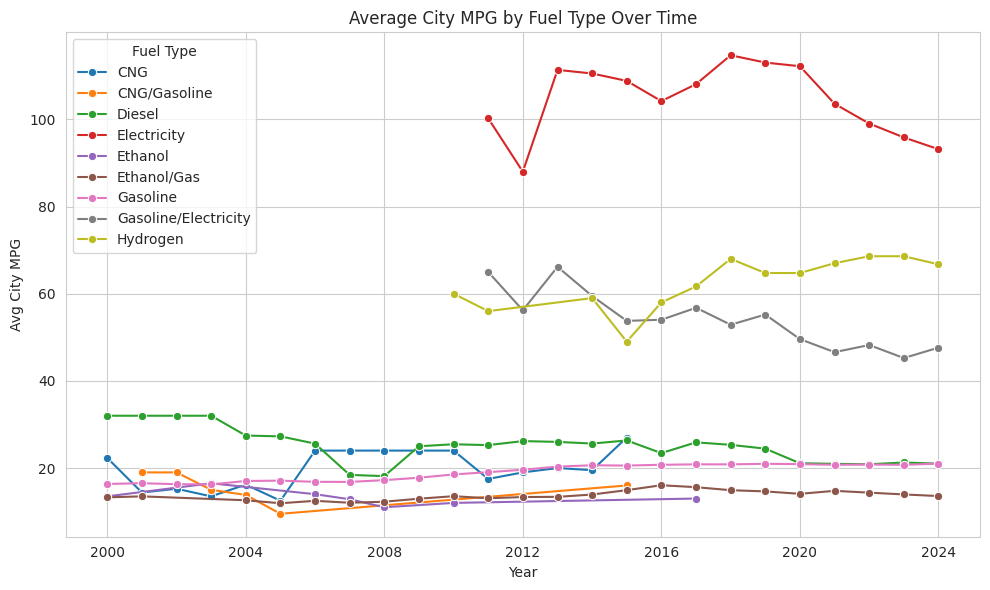

In [75]:
# Set the style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_df, x='Year', y='Avg City MPG', hue='Fuel', marker='o')

# Set the title and labels
plt.title('Average City MPG by Fuel Type Over Time')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')

# Tilt the x-axis labels
# plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Fuel Type')
plt.tight_layout()
plt.show()

## Step 6: Build the model and optimize it

### Time Series Model #1: `Avg City MPG` for Diesel Vehicles

In [76]:
# Subset for records where 'Fuel' is 'Diesel'
fuel_subset = aggregated_df[aggregated_df['Fuel'] == 'Diesel']

# Drop 'Fuel' column
fuel_subset = fuel_subset[['Year', 'Avg City MPG']]

# Set index to 'Year'
fuel_subset = fuel_subset.set_index('Year')

# Obtain time series data
ts = fuel_subset['Avg City MPG']
ts

Year
2000-01-01    32.000000
2001-01-01    32.000000
2002-01-01    32.000000
2003-01-01    32.000000
2004-01-01    27.454545
2005-01-01    27.266667
2006-01-01    25.600000
2007-01-01    18.428571
2008-01-01    18.142857
2009-01-01    25.000000
2010-01-01    25.454545
2011-01-01    25.260870
2012-01-01    26.181818
2013-01-01    26.000000
2014-01-01    25.614035
2015-01-01    26.333333
2016-01-01    23.423077
2017-01-01    25.894737
2018-01-01    25.324324
2019-01-01    24.448276
2020-01-01    21.100000
2021-01-01    20.966667
2022-01-01    20.862069
2023-01-01    21.272727
2024-01-01    21.000000
Name: Avg City MPG, dtype: float64

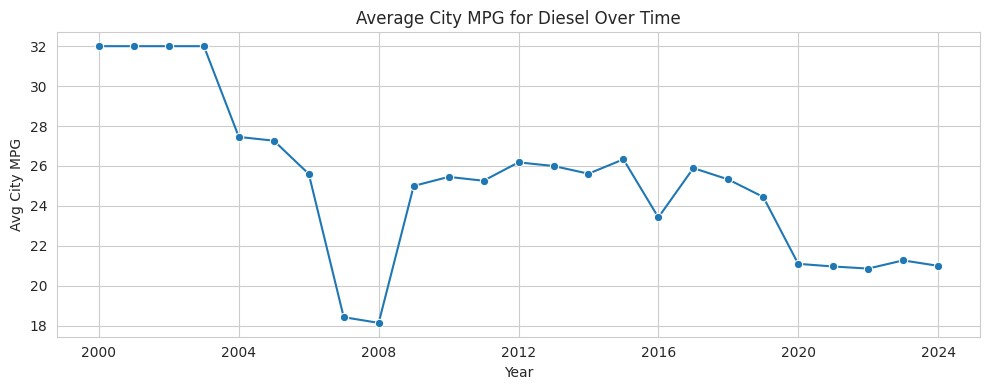

In [77]:
# Set the style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 4))
sns.lineplot(data=ts, marker='o', legend=False)

# Set the title and labels
plt.title('Average City MPG for Diesel Over Time')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')

# Tilt the x-axis labels
# plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### Train/test split

In [78]:
# Split data into 80/20 train/test
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

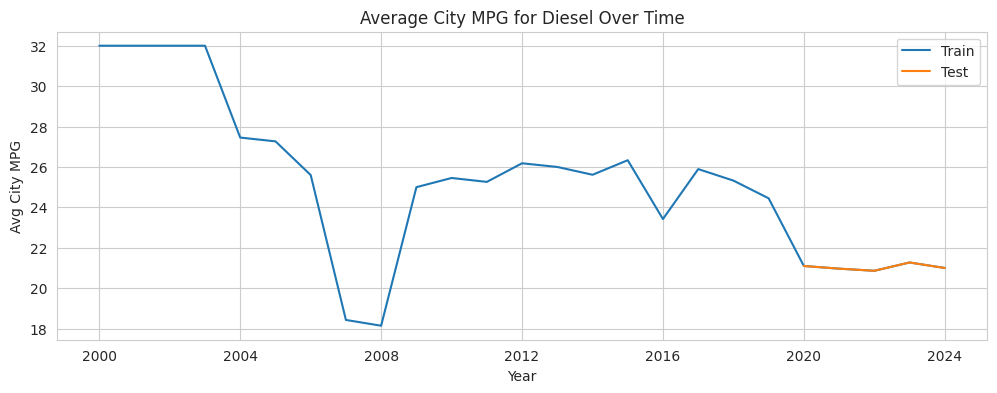

In [79]:
# Plot train and test
plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Average City MPG for Diesel Over Time')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()
plt.show()

#### Check for stationarity and apply differencing if needed
To evaluate the stationarity of the time series we can apply the so-called Dickey-Fuller test, which is a hypothesis test in which the null hypothesis is that the series is stationary, and the alternative is that it is non-stationary:

In [80]:
# Check for stationarity
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Check for stationarity in the train set
test_stationarity(train)

Dickey-Fuller test results:


Test Statistic                 -2.690456
p-value                         0.075704
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

Here we can see that the `p-value` is greater than 0.05, which means that our null hypothesis will be rejected, and we will take this series as non-stationary.

We can apply some sort of transformation to make the time-series stationary. These transformation may include:

1. Differencing the Series (once or more)

2. Take the log of the series

3. Take the nth root of the series

4. Combination of the above

The most commonly used and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

In [81]:
# Apply differencing to train
train_diff = train.diff().dropna()
train_diff

Year
2001-01-01    0.000000
2002-01-01    0.000000
2003-01-01    0.000000
2004-01-01   -4.545455
2005-01-01   -0.187879
2006-01-01   -1.666667
2007-01-01   -7.171429
2008-01-01   -0.285714
2009-01-01    6.857143
2010-01-01    0.454545
2011-01-01   -0.193676
2012-01-01    0.920949
2013-01-01   -0.181818
2014-01-01   -0.385965
2015-01-01    0.719298
2016-01-01   -2.910256
2017-01-01    2.471660
2018-01-01   -0.570413
2019-01-01   -0.876048
Name: Avg City MPG, dtype: float64

Because the `p-value` is less than 0.05, which means that our null hypothesis will be not rejected, and we will take this series as stationary.

In [82]:
# Check for stationarity again
test_stationarity(train_diff)

Dickey-Fuller test results:


Test Statistic                 -4.356589
p-value                         0.000354
#Lags Used                      6.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

Because 1 order of differencing was applied, the $d$ paramater of $\text{ARIMA}(p,d,q)$ will be set to 1.

#### Autocorrelation analysis

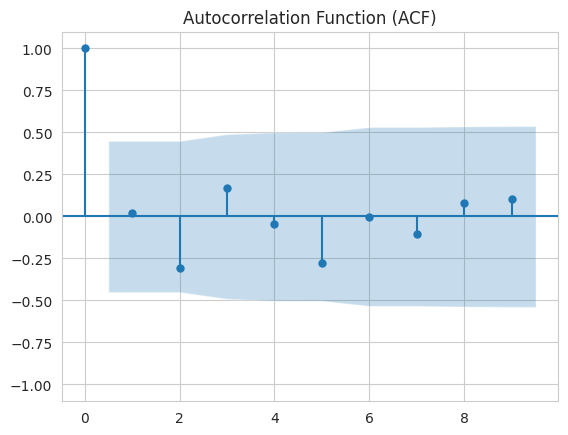

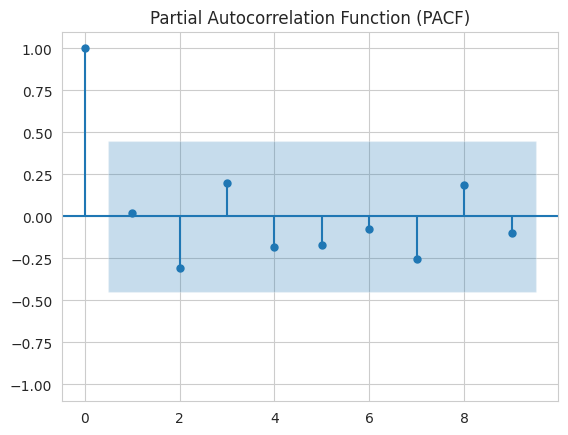

In [83]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

plt.show()

Based on the ACF and PACF plots, the $q$ and $p$ parameters paramater of $\text{ARIMA}(p,d,q)$ will be set to 0. So the model we want to train is $\text{ARIMA}(0,1,0)$.

#### Model training
We can validate the model parameters using the `auto_arima` function.

In [84]:
model = auto_arima(train, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=103.681, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=113.385, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=100.787, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=102.087, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=189.776, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=102.009, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=101.077, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=102.756, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.659 seconds


#### Display Forecast vs Actual & Save to image

In [85]:
# Forecast future predictions
forecast_steps = len(test)
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
forecast

2020-01-01    25.012138
2021-01-01    25.431535
2022-01-01    25.743480
2023-01-01    25.975502
2024-01-01    26.148078
Freq: YS-JAN, dtype: float64

Test RMSE: 4.641


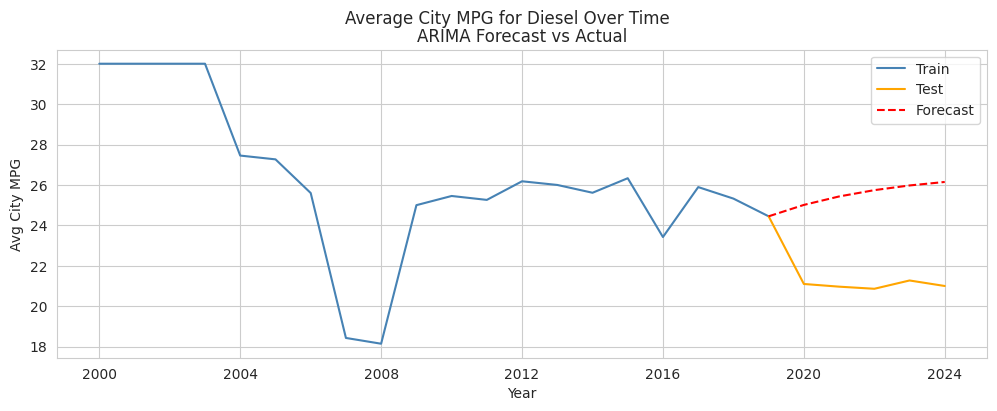

In [86]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)

last_element_index = train.index[-1]  # Get the index of the last train element
last_element_value = train.iloc[-1]   # Get the value of the last train element

# Create a Series with the last element and its index
last_element_series = pd.Series(last_element_value, index=[last_element_index])

# Concatenate the two series
forecast_series = pd.concat([last_element_series, forecast])

# Concatenate the two series
test_series = pd.concat([last_element_series, test])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, color='steelblue', label='Train')
plt.plot(test_series.index, test_series, color='orange', label='Test')
plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.suptitle('Average City MPG for Diesel Over Time')
plt.title('ARIMA Forecast vs Actual', fontsize=12) # subtitle
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/diesel/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show()

#### Make Future `n` Forecasts and Save to Image

##### Retrain the model on entire dataset

In [88]:
# Now, retrain the model on the entire dataset
model.fit(ts)

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

##### Make 1 Forecast Step

In [96]:
# Forecast future predictions
n = 1
forecast, conf_int = model.predict(n_periods=n, return_conf_int=True)
forecast

2025-01-01    21.81707
Freq: YS-JAN, dtype: float64

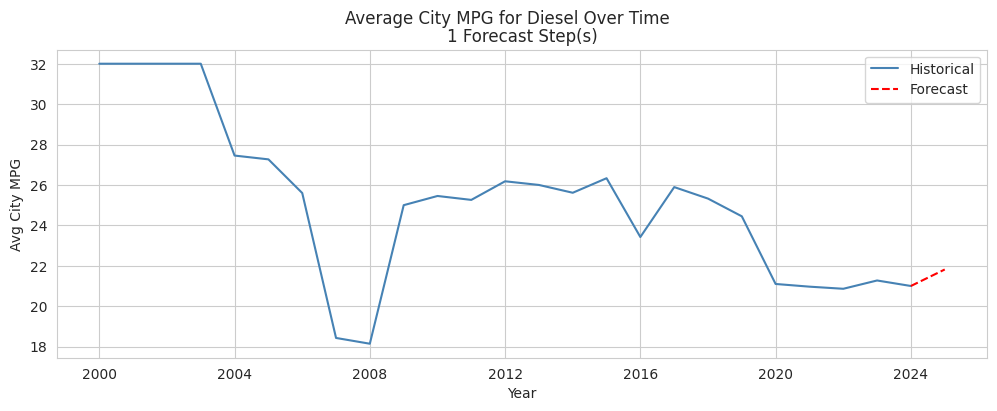

In [95]:
last_element_index = ts.index[-1]  # Get the index of the last ts element
last_element_value = ts.iloc[-1]   # Get the value of the last ts element

# Create a Series with the last element and its index
last_element_series = pd.Series(last_element_value, index=[last_element_index])

# Concatenate the two series
forecast_series = pd.concat([last_element_series, forecast])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(ts.index, ts, color='steelblue', label='Historical')
plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.suptitle('Average City MPG for Diesel Over Time')
plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig(f'../src/static/images/diesel/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

plt.show()

##### Repeat up to 10 Steps

In [99]:
for n in range(1, 11):
    forecast, conf_int = model.predict(n_periods=n, return_conf_int=True)

    last_element_index = ts.index[-1]  # Get the index of the last ts element
    last_element_value = ts.iloc[-1]   # Get the value of the last ts element

    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])

    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(ts.index, ts, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Diesel Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/diesel/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

Repeat the process with other vehicle segments.